In [1]:
# Load google drive and navigate to src directory
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/NN Proj/pytorch-ocr/src'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NN Proj/pytorch-ocr/src


In [2]:
# If not already installed (e.g. on google colab), install all required packages
# with the following command:

# !pip install -r ../requirements.txt

In [3]:
import string
import torch

from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import CTCLabelEncoder
from train import CTCModelTrainer
from dataset import CaptchaLoader, split_dataset
from crnn import CRNN
from test_eval import CTCModelTesterEvaluator
from plotting import show_sample_data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")
torch.manual_seed(0)
%matplotlib inline

Current device: cuda


In [5]:
# Hyperparams
source_dir = Path('../data/captcha/raw')
train_dir = Path('../data/captcha/train')
test_dir = Path('../data/captcha/test')
val_dir = Path('../data/captcha/val')

model_path = Path('../models/captcha/crnn.pt')

alphabet = string.ascii_lowercase + string.digits
label_encoder = CTCLabelEncoder(alphabet)

n_workers = 2
batch_size = 8
hidden_size = 256
vocab_size = len(alphabet) + 1 # extra character for blank symbol
dropout = 0.3
weight_decay = 1e-5
momentum = 0.9
clip_norm = 5
num_epochs = 50
learning_rate = 0.025
use_resnet18 = True
use_pretrained_model = True

print(f"Alphabet: {alphabet}")
print(f"Vocab size: {vocab_size}")

Alphabet: abcdefghijklmnopqrstuvwxyz0123456789
Vocab size: 37


In [6]:
split_dataset(source_dir, train_dir, test_dir, val_dir, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1)

One or more target directories are not empty. Skipping dataset split.


In [7]:
train_dataset = CaptchaLoader(train_dir)
test_dataset = CaptchaLoader(test_dir)
val_dataset = CaptchaLoader(val_dir)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=False)

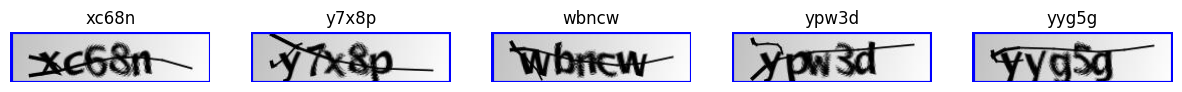

In [8]:
show_sample_data(val_dataloader)

In [9]:
crnn = CRNN(hidden_size=hidden_size,
            vocab_size=vocab_size,
            dropout=dropout,
            use_resnet18=use_resnet18,
            use_pretrained=use_pretrained_model
            ).to(device)

In [10]:
optimizer = optim.SGD(crnn.parameters(),
                      lr=learning_rate,
                      nesterov=True,
                      weight_decay=weight_decay,
                      momentum=momentum)

criterion = nn.CTCLoss(blank=0, zero_infinity=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

### Train Model

In [11]:
trainer = CTCModelTrainer(model=crnn,
                          optimizer=optimizer,
                          criterion=criterion,
                          label_encoder=label_encoder,
                          train_dataloader=train_dataloader,
                          val_dataloader=val_dataloader,
                          model_path=model_path,
                          scheduler=scheduler,
                          clip_norm=clip_norm
                          )

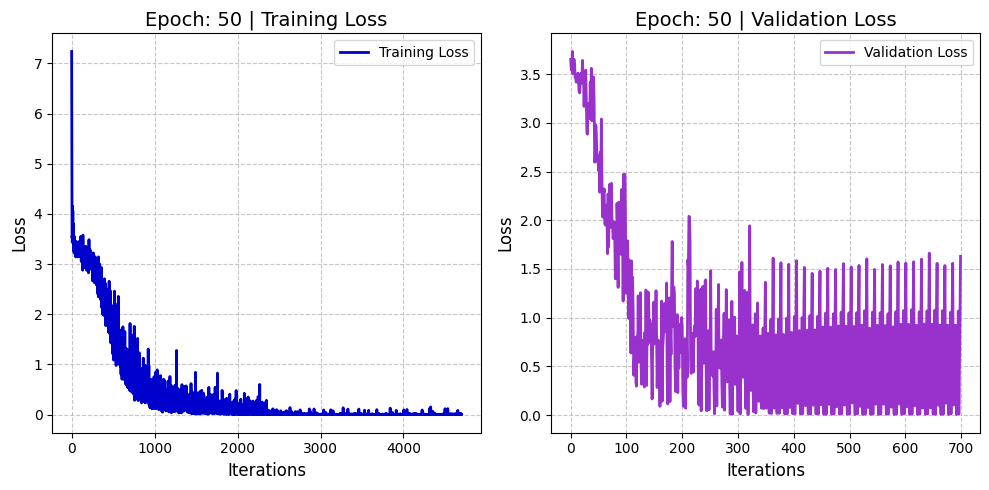

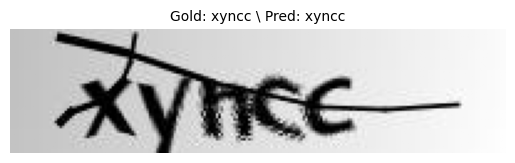

╭──────────────╮ ╭────────────────────╮ ╭──────────────────╮ ╭───────────────────────────╮
│ Epoch: 50/50 │ │ Train Loss: 0.0046 │ │ Val Loss: 0.5398 │ │ Learning Rate: 0.00000250 │
╰──────────────╯ ╰────────────────────╯ ╰──────────────────╯ ╰───────────────────────────╯

Model saved to ../models/captcha/crnn.pt


In [12]:
trainer.train(num_epochs=num_epochs)

### Evaluate model

In [13]:
crnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
tester_evaluator = CTCModelTesterEvaluator(model=crnn,
                                           test_dataset=test_dataset,
                                           label_encoder=label_encoder,
                                           device=device,
                                           alphabet=alphabet)

In [15]:
tester_evaluator.test()

Output()

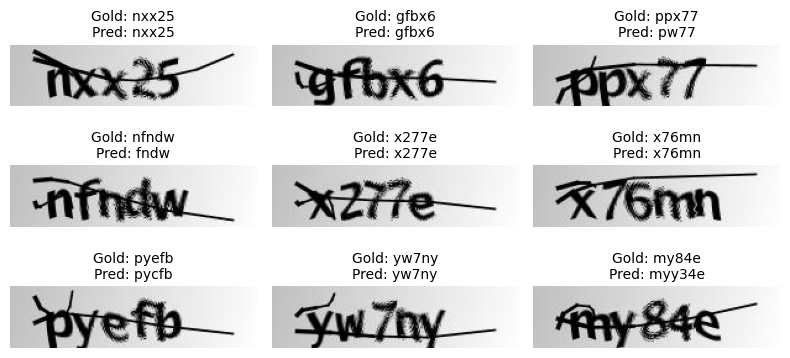

╭─────────────────────────────╮ ╭───────────────────────────────╮
│ Word-level Accuracy: 0.5654 │ │ Char-level BLEU Score: 0.8950 │
╰─────────────────────────────╯ ╰───────────────────────────────╯

In [16]:
tester_evaluator.print_results()

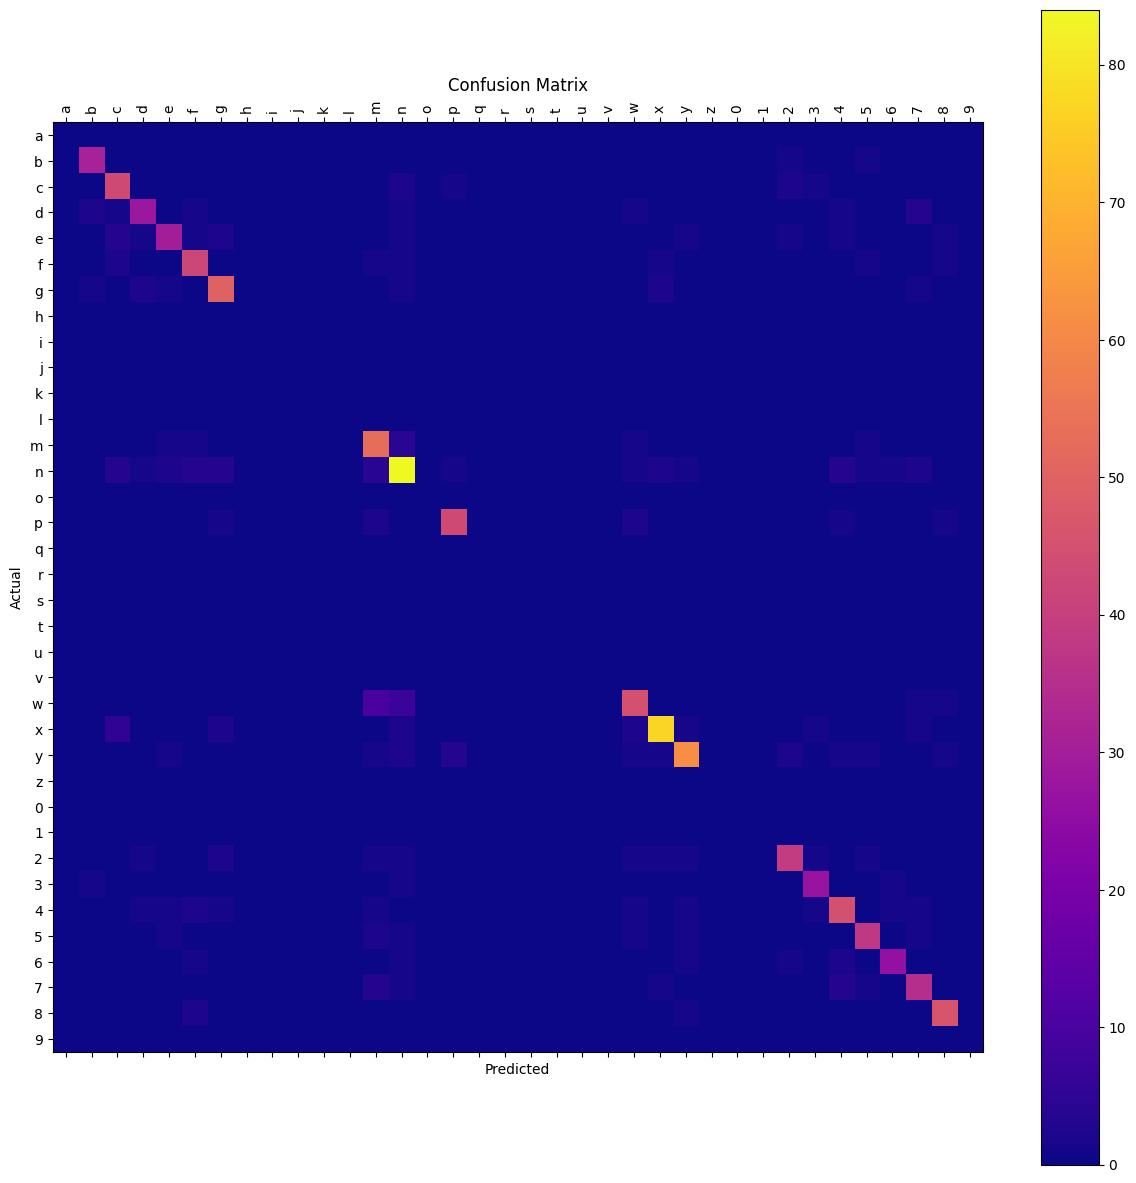

In [17]:
tester_evaluator.print_confusion_matrix()